### Упражнение 1
* Реализуйте функцию `get_geodesic_distance`, рассчитывающее геодезическое расстояние между двумя точками в километрах.

In [163]:
!pip install folium
!pip install pandas==1.1.5
!pip install fiona==1.8.18
!pip install numpy==1.19.5
!pip install shapely==1.7.1
!pip install rtree==0.9.7
!pip install pyproj==3.0.1
!pip install matplotlib==3.3.4
!pip install mapclassify==2.4.2
!pip install geopy==2.1.0
!pip install psycopg2==2.7.6.1
!pip install geoalchemy2==0.8.5
!pip install pyarrow==3.0.0
!pip install pygeos==0.9
!pip install geopandas==0.9.0

  Using cached psycopg2-2.7.6.1.tar.gz (427 kB)
    ERROR: Command errored out with exit status 1:
     command: /Users/w3dip/opt/anaconda3/bin/python -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/yx/wf85z_l50hb23jwhzfmzztcm0000gn/T/pip-install-i9vo41m2/psycopg2_df00df6b9dbc4e6884376d508dd3beb3/setup.py'"'"'; __file__='"'"'/private/var/folders/yx/wf85z_l50hb23jwhzfmzztcm0000gn/T/pip-install-i9vo41m2/psycopg2_df00df6b9dbc4e6884376d508dd3beb3/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/yx/wf85z_l50hb23jwhzfmzztcm0000gn/T/pip-pip-egg-info-rdepkt7k
         cwd: /private/var/folders/yx/wf85z_l50hb23jwhzfmzztcm0000gn/T/pip-install-i9vo41m2/psycopg2_df00df6b9dbc4e6884376d508dd3beb3/
    

In [20]:
import folium
import geopy
from geopy.geocoders import Yandex, GoogleV3
import pandas as pd
from shapely.geometry import Polygon, Point, LineString
import numpy as np

#ключ не идет в составе репозитория
with open('api_key.txt', 'r') as f:
    api_key = f.read()
    
geolocator_google = GoogleV3(api_key=api_key)

In [164]:
from geopy.distance import geodesic, great_circle

def get_geodesic_distance(a, b):
    r = 6371
    lat1 = a.x
    lon1 = a.y
    lat2 = b.x
    lon2 = b.y
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

mipt = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)

print(get_geodesic_distance(mipt, kremlin))
print(great_circle((mipt.x, mipt.y), (kremlin.x, kremlin.y)).km)
print(geodesic((mipt.x, mipt.y), (kremlin.x, kremlin.y)).km)

20.68
20.67698120510216
20.707551240164566


### Упражнение 2

* Реализуйте функцию `get_k_nearest_neighbours_by_dist`, осуществляющую поиск `k` ближайших соседей полигона из заданного списка на основе геодезического расстояния. Добавьте две возможности учета расстояния: через ближайшие точки на границах полигонов и через центроиды полигонов.

In [180]:
import geopandas as gpd
import warnings
import random
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

big_moscow_districts = gpd.read_file('big_moscow_districts.shp')
polygon = random.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
polygons = random.sample(big_moscow_districts['geometry'].tolist(), 50)

def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    dists = []
    for item in polygons:
        if kind == 'by_centroid':
            a = item.centroid
            b = polygon.centroid
        
        if kind == 'by_board':
            a, b = nearest_points(polygon, item)
            
        dist = get_geodesic_distance(a, b)
        dists.append((dist, item))

    dists.sort(key=lambda x: x[0])
    return gpd.GeoSeries([x[1] for x in dists[:k+1]])

k_nearest_neighbours_by_board = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_board')
k_nearest_neighbours_by_centroid = get_k_nearest_neighbours_by_dist(polygon, polygons, k=10, kind='by_centroid')
k_nearest_neighbours_by_centroid

0     POLYGON ((37.79356 55.62296, 37.79213 55.62217...
1     POLYGON ((37.85818 55.70125, 37.85732 55.70070...
2     POLYGON ((37.77585 55.61827, 37.77557 55.61803...
3     POLYGON ((37.84268 55.74907, 37.84254 55.74718...
4     POLYGON ((37.79912 55.72211, 37.79857 55.72058...
5     POLYGON ((37.78505 55.61682, 37.78475 55.61683...
6     POLYGON ((37.75612 55.69137, 37.75606 55.69121...
7     POLYGON ((37.84254 55.74718, 37.84265 55.74673...
8     POLYGON ((37.73044 55.61303, 37.73016 55.61298...
9     POLYGON ((37.73489 55.68743, 37.73449 55.68637...
10    POLYGON ((37.75422 55.75875, 37.75401 55.75871...
dtype: geometry

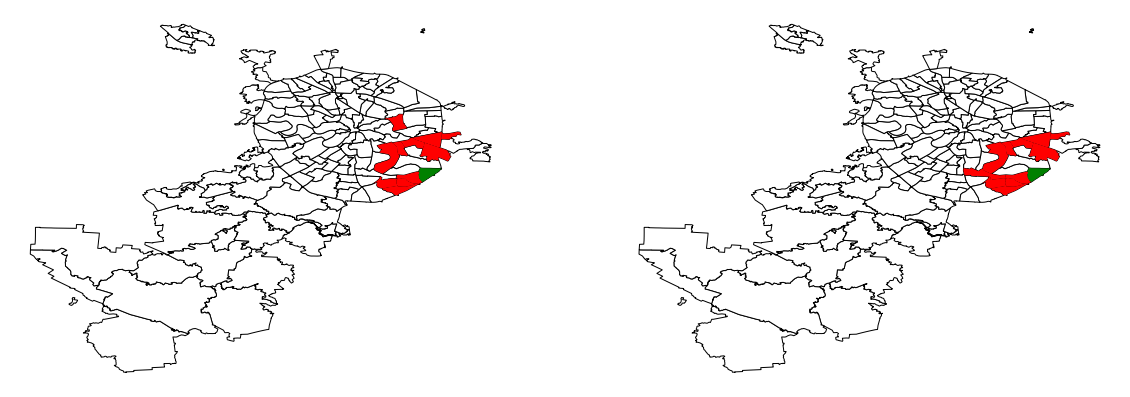

In [181]:
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_nearest_neighbours_by_board.plot(ax=ax, color='red')
gpd.GeoSeries(polygon).plot(ax=ax, color='green')
ax.set_axis_off()

### Упражнение 3 (*)
* Реализуйте функцию `spatial_resample`, выполняющую пространственное агрегирование. 
  На вход функция принимает:
  - `init_polygons` - изначальное гео-разбиение
  - `agg_polygons` - новое гео-разбиение, по которому будет проводится пространственное агрегирование
  - `column` - название столбца количественной переменной в `init_polygons`, которая будет агрегирована  
  - `method` - метод аггрегирования: `sum` - сумма значений, `mean` - среднее значение
  - `kind` - способ аггрегирования при частичном пересечении полигонов из `agg_polygons` и `init_polygons`, `max` - отнести значение в `column` к полигону из `agg_polygons` с которым площадь пересечения максимальна, `prop` - разбить значение в `column` пропорционально площадям пересечений

In [4]:
# Сигнатура функции и пример вывода:

grid_big_moscow = gpd.read_file('../data/grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

mean_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
sum_resample_table = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='sum', column='random_value', kind='max')
mean_resample_table.head()

agg_index                                           geometry  random_value
0          0  POLYGON ((37.68525 55.89508, 37.68891 55.89504...     49.814815
1          1  POLYGON ((37.60716 55.87932, 37.60754 55.87911...     47.923077
2          2  POLYGON ((37.64437 55.89768, 37.65226 55.89678...     45.807692
3          3  POLYGON ((37.49625 55.89248, 37.49851 55.89347...     58.322581
4          4  POLYGON ((37.41143 55.87096, 37.40632 55.87426...     46.446809

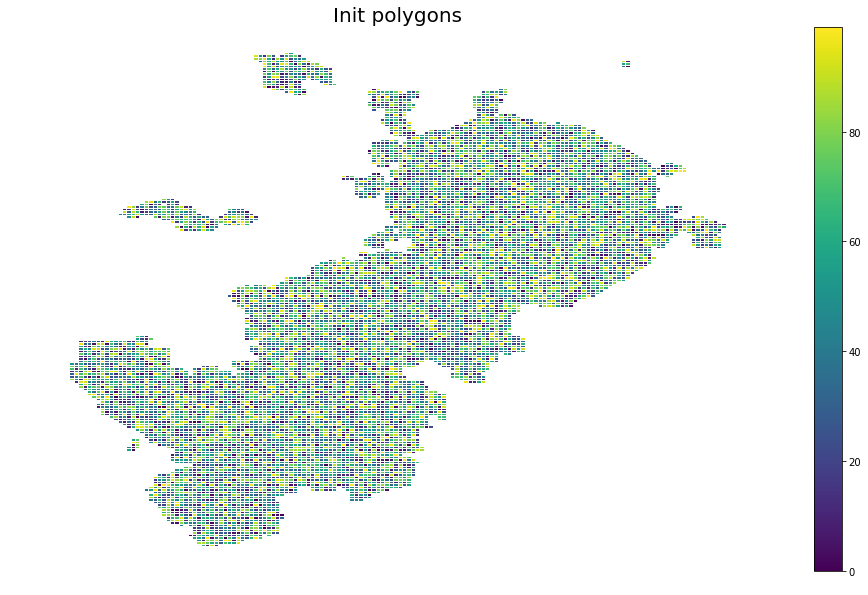

In [5]:
fig = plt.figure(figsize=(20, 10))
plt.title('Init polygons', fontsize=20)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

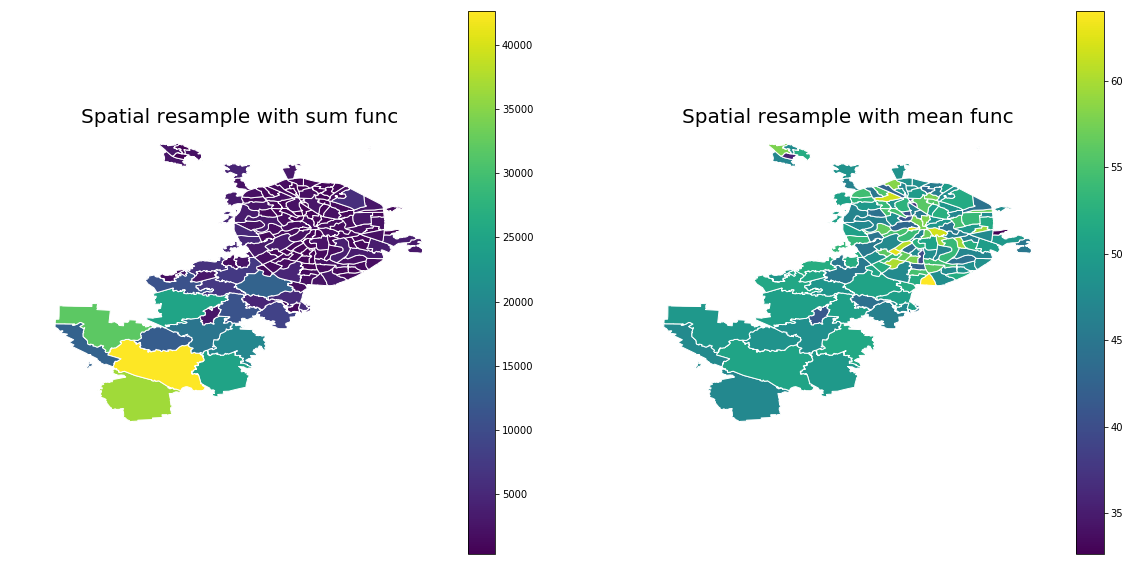

In [6]:
###

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plt.title('Spatial resample with sum func', fontsize=20)
sum_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample with mean func', fontsize=20)
mean_resample_table.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

### Упражнение 4
* Отобразите результаты упражнений 2 и 3 (рисунки с `###`) на интерактивной карте в `Folium`

In [182]:
m = folium.Map(location=[55.755826, 37.6172999], zoom_start=9)
df = big_moscow_districts
for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)

target = gpd.GeoSeries(polygon)
folium.Choropleth(target.to_json(), fill_color='red').add_to(m)
around_target = gpd.GeoSeries(k_nearest_neighbours_by_centroid)
folium.Choropleth(around_target.to_json(), fill_color='green').add_to(m) 
m

In [183]:
m = folium.Map(location=[55.755826, 37.6172999], zoom_start=9)
df = big_moscow_districts
for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)

target = gpd.GeoSeries(polygon)
folium.Choropleth(target.to_json(), fill_color='red').add_to(m)
around_target = gpd.GeoSeries(k_nearest_neighbours_by_board)
folium.Choropleth(around_target.to_json(), fill_color='green').add_to(m) 
m